# Hypothesis Testing 

We are going to perform Z-test, analysing a Netflix dataset, to account that whether the Dwell time have any effect with introducing 2 adds.

Group A --> Treatment Group shown 2 ads per ad-break

Group B --> Control Group shown only 1 ad per ad break

Let us comapre mean watch-times per group

H0: mu1= mu2

H1: mu1 != mu2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy

In [2]:
# Download data
# https://drive.google.com/file/d/1Hl96n6BWdl3ruJgCo_gaAWEb0kEYg__H/view?usp=sharing
id = "1Hl96n6BWdl3ruJgCo_gaAWEb0kEYg__H"
path = "https://docs.google.com/uc?export=download&id=" + id
print(path)

https://docs.google.com/uc?export=download&id=1Hl96n6BWdl3ruJgCo_gaAWEb0kEYg__H


In [3]:
!wget "https://docs.google.com/uc?export=download&id=1Hl96n6BWdl3ruJgCo_gaAWEb0kEYg__H" -O ab_test_data.csv
# wget is a URL network downloader that can work in the background, and it helps in downloading files directly from the main server

--2022-07-25 19:46:12--  https://docs.google.com/uc?export=download&id=1Hl96n6BWdl3ruJgCo_gaAWEb0kEYg__H
Resolving docs.google.com (docs.google.com)... 142.251.111.101, 142.251.111.113, 142.251.111.138, ...
Connecting to docs.google.com (docs.google.com)|142.251.111.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0ush6dqdjru99bul4mar31kdb2vcqoq7/1658778300000/10804243441129704195/*/1Hl96n6BWdl3ruJgCo_gaAWEb0kEYg__H?e=download&uuid=0a0d5de6-60df-4e0e-9f77-c81a27e3175d [following]
--2022-07-25 19:46:12--  https://doc-00-ag-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0ush6dqdjru99bul4mar31kdb2vcqoq7/1658778300000/10804243441129704195/*/1Hl96n6BWdl3ruJgCo_gaAWEb0kEYg__H?e=download&uuid=0a0d5de6-60df-4e0e-9f77-c81a27e3175d
Resolving doc-00-ag-docs.googleusercontent.com (doc-00-ag-docs.googleusercontent.com)... 172.253.122.132, 2607:

In [4]:
!ls -lrt
# listing the directory contents.

total 872
drwxr-xr-x 1 root root   4096 Jul 13 13:43 sample_data
-rw-r--r-- 1 root root 887610 Jul 25 19:46 ab_test_data.csv


In [18]:
#!cat ab_test_data.csv
# used to display the content of files

In [6]:
ab_test_data = pd.read_csv("ab_test_data.csv")
# taking 100 samples
ab_test_data.sample(100)

,date,customer_id,premium,watch_time_hrs,customer_segmnt
16987,2018-04-01,446,0,3.874986,control
19499,2018-03-09,807,0,2.990503,treatment
10143,2018-03-22,478,0,1.783394,control
13391,2018-09-13,909,0,2.396431,treatment
15965,2018-07-28,446,1,1.236874,control
...,...,...,...,...,...
508,2018-02-21,432,0,3.149271,control
12988,2018-10-23,603,1,2.969893,treatment
570,2018-09-18,885,0,1.928054,treatment
11344,2018-05-20,941,0,2.111601,treatment


In [8]:
ab_test_data.shape

(20000, 5)

In [10]:
# we need to know value counts of Test vs Control.
ab_test_data['customer_segmnt'].value_counts()
# n1=n2=10000 => we can do t-test or z-test to compare means.

control      10000
treatment    10000
Name: customer_segmnt, dtype: int64

In [26]:
ab_test_data.describe()

,customer_id,premium,watch_time_hrs
count,20000.000000,20000.000000,20000.000000
mean,499.001650,0.176750,9.362542
std,288.223444,0.381467,244.884839
min,0.000000,0.000000,0.160268
25%,249.000000,0.000000,1.678066
50%,500.000000,0.000000,2.670953
75%,747.000000,0.000000,4.204673
max,999.000000,1.000000,10007.648185


There as for sure some ouliers as max watch_time_hrs is too large.

Here, watch_time_hrs = Dwell time for next 24 hrs.

In [13]:
# remove extreme values as we dont want them to impact means 
ab_test_data["watch_time_hrs"].quantile(0.999)

# here, we are computing the 99.9th %ile value.
# NOTE: only 24 hrs in a day

26.036198684124518

In [14]:
# iterating again for 99.8th %ile value.
ab_test_data["watch_time_hrs"].quantile(0.998)

21.356607722117484

In [16]:
q998 = ab_test_data["watch_time_hrs"].quantile(0.998)

# removing Outliers
ab_test_data_no_out = ab_test_data[~(ab_test_data["watch_time_hrs"] > q998)]

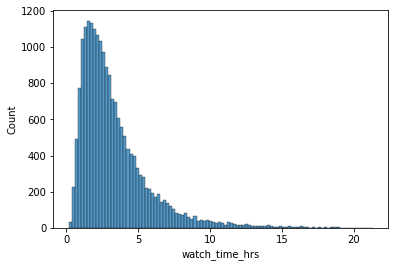

In [17]:
# disb of watch-time
sns.histplot(ab_test_data_no_out['watch_time_hrs'], bins=100)
plt.show()

In [19]:
#split the data
ab_test_control_data = ab_test_data_no_out[ab_test_data_no_out["customer_segmnt"] == "control"]
ab_test_treatment_data = ab_test_data_no_out[ab_test_data_no_out["customer_segmnt"] == "treatment"]

In [20]:
ab_test_control_data.shape

(9973, 5)

In [21]:
ab_test_treatment_data.shape

(9987, 5)

In [24]:
# 2-sample z-test as n1 nad n2 are large.
# Refer: https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html
from statsmodels.stats.weightstats import ztest as ztest
ztest(ab_test_control_data["watch_time_hrs"], ab_test_treatment_data["watch_time_hrs"])

(15.96034913022092, 2.4137738128170024e-57)

This returns two parameters

(T_observed, p_value)

Since p_value is way than than significance value, alpha say even 0.001%.

So, we reject out NULL hypothesis that mu1= mu2.

And there is observable effect on watch_time_hrs, with introducing 2 adds.